In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import matplotlib.pyplot as plt
import optuna
import joblib
import mlflow
import mlflow.sklearn
import warnings
warnings.filterwarnings('ignore')

In [39]:
# Cargar los datos
df = pd.read_csv('stroke_dataset.csv')

In [40]:
# Define las columnas
cat_cols = ['gender', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']  # Todas las variables categóricas
num_cols = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']  # Variables numéricas

# Imprimir los 10 primeros registros de todas las columnas
print(df.head(10))

   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1    Male  80.0             0              1          Yes        Private   
2  Female  49.0             0              0          Yes        Private   
3  Female  79.0             1              0          Yes  Self-employed   
4    Male  81.0             0              0          Yes        Private   
5    Male  74.0             1              1          Yes        Private   
6  Female  69.0             0              0           No        Private   
7  Female  78.0             0              0          Yes        Private   
8  Female  81.0             1              0          Yes        Private   
9  Female  61.0             0              1          Yes       Govt_job   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural         

In [43]:

# Aplicar LabelEncoder a cada columna categórica
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Preprocesamiento simplificado usando LabelEncoder
preprocessor = ColumnTransformer(
    transformers=[
        # Escalar las variables numéricas
        ('num', StandardScaler(), num_cols)
    ],
    remainder='passthrough'  # Mantener las columnas categóricas ya codificadas
)

(4981, 11)


In [24]:
# Separar características y objetivo
X = df[cat_cols + num_cols]
y = df['stroke']

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Función para crear el pipeline con SMOTE
def create_pipeline(classifier):
    return ImbPipeline([
        ('preprocessor', preprocessor), # preprocesamiento
        ('smote', SMOTE(random_state=42)), # Synthetic Minority Over-sampling Technique
        ('classifier', classifier) # clasificador
    ])

In [26]:
# Función para evaluar el modelo
def evaluate_model(y_true, y_pred, y_pred_proba):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba)
    }

In [27]:
# Diccionario de modelos
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'LightGBM': LGBMClassifier(),
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0)
}

In [28]:
# Entrenar y evaluar modelos
results = {}
best_model = None
best_auc = 0

for name, model in models.items():
    pipeline = create_pipeline(model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    metrics = evaluate_model(y_test, y_pred, y_pred_proba)
    results[name] = metrics
    
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")
    
    if metrics['auc'] > best_auc:
        best_auc = metrics['auc']
        best_model = (name, pipeline)

print(f"\nBest model: {best_model[0]} with AUC = {best_auc:.4f}")


Logistic Regression:
accuracy: 0.7362
precision: 0.1433
recall: 0.7778
f1: 0.2421
auc: 0.8445

Random Forest:
accuracy: 0.9117
precision: 0.0526
recall: 0.0370
f1: 0.0435
auc: 0.7826
[LightGBM] [Info] Number of positive: 3790, number of negative: 3790
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 7580, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM:
accuracy: 0.9137
precision: 0.1000
recall: 0.0741
f1: 0.0851
auc: 0.7732

XGBoost:
accuracy: 0.9208
precision: 0.0968
recall: 0.0556
f1: 0.0706
auc: 0.7741

CatBoost:
accuracy: 0.9188
precision: 0.1143
recall: 0.0741
f1: 0.0899
auc: 0.7418

Best model: Logistic Regression with AUC = 0.8445


In [29]:
# Optimización de hiperparámetros con Optuna
def objective(trial):
    if best_model[0] == 'Logistic Regression':
        solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])
        
        if solver == 'liblinear':
            penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        else:
            penalty = 'l2'  # lbfgs solo soporta 'l2' o None
        
        classifier = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e5),
            solver=solver,
            penalty=penalty,
            random_state=42
        )
    elif best_model[0] == 'Random Forest':
        classifier = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 1000),
            max_depth=trial.suggest_int('max_depth', 2, 32),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
            min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20)
        )
    elif best_model[0] == 'LightGBM':
        classifier = LGBMClassifier(
            num_leaves=trial.suggest_int('num_leaves', 2, 256),
            max_depth=trial.suggest_int('max_depth', 3, 16),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000)
        )
    elif best_model[0] == 'XGBoost':
        classifier = XGBClassifier(
            max_depth=trial.suggest_int('max_depth', 1, 9),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            n_estimators=trial.suggest_int('n_estimators', 100, 1000),
            min_child_weight=trial.suggest_int('min_child_weight', 1, 300)
        )
    else:  # CatBoost
        classifier = CatBoostClassifier(
            iterations=trial.suggest_int('iterations', 100, 1000),
            depth=trial.suggest_int('depth', 4, 10),
            learning_rate=trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
            l2_leaf_reg=trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100),
            verbose=0
        )
    
    pipeline = create_pipeline(classifier)
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_val_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        
        auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        auc_scores.append(auc)
    
    return np.mean(auc_scores)

In [30]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Entrenar el mejor modelo con los mejores hiperparámetros
best_params = study.best_params
best_classifier = models[best_model[0]]
best_classifier.set_params(**best_params)
best_pipeline = create_pipeline(best_classifier)
best_pipeline.fit(X_train, y_train)

[I 2024-10-26 01:06:10,938] A new study created in memory with name: no-name-10619752-40ea-454c-a7a1-12b91ddd98a1
[I 2024-10-26 01:06:11,123] Trial 0 finished with value: 0.8291898561097284 and parameters: {'solver': 'lbfgs', 'C': 3.99738332683808}. Best is trial 0 with value: 0.8291898561097284.
[I 2024-10-26 01:06:11,396] Trial 1 finished with value: 0.8291013712482954 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 42186.73153253398}. Best is trial 0 with value: 0.8291898561097284.
[I 2024-10-26 01:06:11,557] Trial 2 finished with value: 0.836196005540541 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.018297108710831615}. Best is trial 2 with value: 0.836196005540541.
[I 2024-10-26 01:06:11,822] Trial 3 finished with value: 0.8291081366904169 and parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 166.47011747023902}. Best is trial 2 with value: 0.836196005540541.
[I 2024-10-26 01:06:12,092] Trial 4 finished with value: 0.829128433016782 and para

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 LogisticRegression(C=0.012557614443376395, penalty='l1',
                                    solver='liblinear'))])

In [31]:
# Evaluar el modelo optimizado
y_pred_optimized = best_pipeline.predict(X_test)
y_pred_proba_optimized = best_pipeline.predict_proba(X_test)[:, 1]
metrics_optimized = evaluate_model(y_test, y_pred_optimized, y_pred_proba_optimized)

print(f"\nBest model after optimization: {best_model[0]}")
print(f"Best parameters: {best_params}")
print("\nOptimized model metrics:")
for metric, value in metrics_optimized.items():
    print(f"{metric}: {value:.4f}")


Best model after optimization: Logistic Regression
Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.012557614443376395}

Optimized model metrics:
accuracy: 0.7212
precision: 0.1433
recall: 0.8333
f1: 0.2446
auc: 0.8463


In [32]:
# Calcular e imprimir el overfitting
y_train_pred_proba = best_pipeline.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_pred_proba)
overfitting = train_auc - metrics_optimized['auc']
print(f"\nTrain AUC: {train_auc:.4f}")
print(f"Overfitting: {overfitting:.4f}")


Train AUC: 0.8410
Overfitting: -0.0053


In [33]:
# Guardar el pipeline completo en un archivo pickle
joblib.dump(best_pipeline, 'full_stroke_prediction_pipeline.pkl')
print(f"\nFull pipeline saved as: 'full_stroke_prediction_pipeline.pkl'")


Full pipeline saved as: 'full_stroke_prediction_pipeline.pkl'


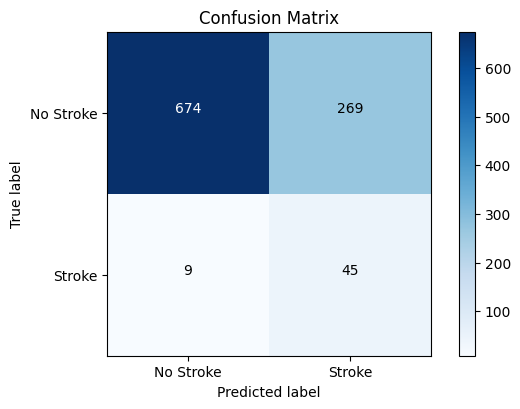

In [34]:
# Visualizar matriz de confusión
cm = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
plt.show()

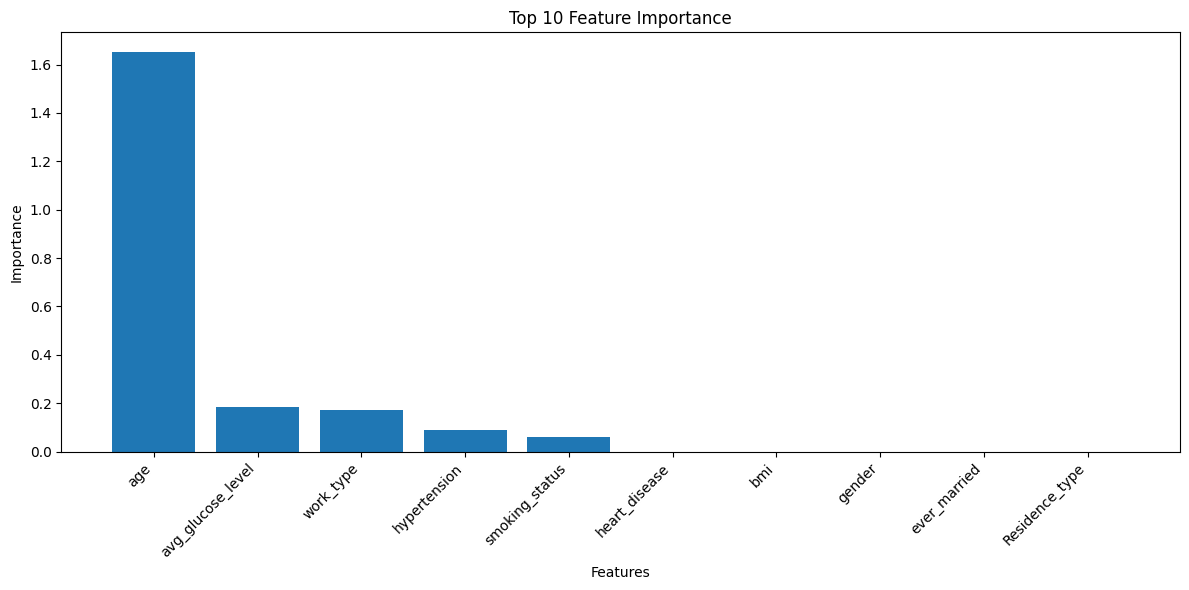


Feature Importance:
age: 1.6506
avg_glucose_level: 0.1854
work_type: 0.1705
hypertension: 0.0890
smoking_status: 0.0622
heart_disease: 0.0000
bmi: 0.0000
gender: 0.0000
ever_married: 0.0000
Residence_type: 0.0000


In [48]:
# Extraer el clasificador del pipeline
classifier = best_pipeline.named_steps['classifier']
X_train_transformed = best_pipeline.named_steps['preprocessor'].transform(X_train)

# Obtener los nombres de las características después del preprocesamiento
feature_names = num_cols + cat_cols

# Determinar la importancia de las características
if hasattr(classifier, 'feature_importances_'):
    # Para Random Forest, XGBoost, LightGBM y CatBoost
    importances = classifier.feature_importances_
elif hasattr(classifier, 'coef_'):
    # Para Regresión Logística
    importances = np.abs(classifier.coef_[0])
else:
    print("Feature importance no disponible para este tipo de clasificador.")
    importances = None

# Visualizar la importancia de las características si está disponible
if importances is not None:
    # Crear un DataFrame con las características y sus importancias
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Visualizar las 10 características más importantes
    plt.figure(figsize=(12, 6))
    plt.bar(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
    plt.title('Top 10 Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Imprimir la importancia de todas las características
    print("\nFeature Importance:")
    for index, row in feature_importance_df.iterrows():
        print(f"{row['feature']}: {row['importance']:.4f}")